Set True to save the figures.

In [83]:
save = False

In [142]:
import numpy as np # scientific computing
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # reading images
import math # definition for pi to use with radians for identifying neighboring sectors during maxima suppression
from skimage.color import rgb2gray # converting rgb images to grayscale
import cv2 as cv


Read images and convert them to grayscale.

In [129]:

img1 = cv2.imread('edge2.png', 0)

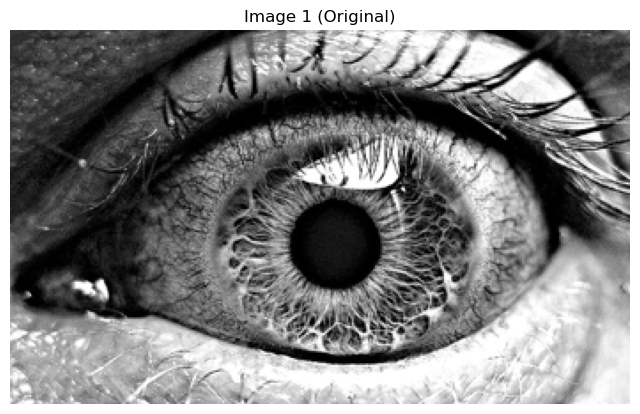

In [123]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Image 1 (Original)')
plt.imshow(img1, cmap='gray')
if save:
    plt.savefig('original1.png')
plt.show()

2D-convolution (actually cross-correlation)

In [124]:
def cross_correlate2D(img, mask):
    n_r, n_c = img.shape
    # Compute row and column offsets
    mask_r, mask_c = mask.shape
    r_offset = mask_r // 2 - (mask_r % 2 == 0)
    c_offset = mask_c // 2 - (mask_c % 2 == 0)
    # Apply zero-padding 
    padded_img = np.pad(img, ((r_offset, r_offset + (mask_r % 2 == 0)),
                              (c_offset, c_offset + (mask_c % 2 == 0))))
    # Perform 2D cross-correlation
    output = np.zeros((n_r, n_c))
    for row in range(r_offset, r_offset + n_r):
        for col in range(c_offset, c_offset + n_c):
            output[row - r_offset, col - c_offset] = np.sum(
                mask *
                padded_img[row - r_offset: row + r_offset + (mask_r % 2 == 0) + 1, 
                           col - c_offset: col + c_offset + (mask_c % 2 == 0) + 1]
            )
    return output

Sobel Operator:

In [125]:
def sobel(img):
    mask_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    mask_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    edge_x = cross_correlate2D(img, mask_x) / 6
    edge_y = cross_correlate2D(img, mask_y) / 6
    gradient_magnitudes = np.sqrt(edge_x ** 2 + edge_y ** 2)
    gradient_magnitudes *= 255 / np.max(gradient_magnitudes)
    gradient_directions = np.arctan2(edge_y, edge_x)
    return edge_x, edge_y, gradient_magnitudes, gradient_directions

Plotting code is refactored as a seperate function to avoid duplicate code. Feel free to change it.

In [130]:
def plot_results1(result1, result2, result3, result4, figsize_, method, img_number, save=False):
    fig, axs = plt.subplots(2, 2, figsize=figsize_)
    axs[0, 0].set_title('Vertical Edges after applying \n' + method + ' Operator to Image ' + img_number)
    axs[0, 0].axis('off')
    axs[0, 0].imshow(result1, cmap='gray')
    axs[0, 1].set_title('Horizontal Edges after applying \n' + method + ' Operator to Image ' + img_number)
    axs[0, 1].axis('off')
    axs[0, 1].imshow(result2, cmap='gray')
    axs[1, 0].set_title('Combined Edges of Image ' + img_number + '\n (Gradient Magnitudes (' + method + '))')
    axs[1, 0].axis('off')
    axs[1, 0].imshow(result3, cmap='gray')
    axs[1, 1].set_title('Gradient Directions (' + method + ') in Image ' + img_number)
    axs[1, 1].axis('off')
    axs[1, 1].imshow(result4)
    if save:
        plt.savefig(method + '_results' + img_number + '.png')
    plt.show()

In [131]:
sobel_x1, sobel_y1, sobel_magnitudes1, sobel_directions1 = sobel(img1)

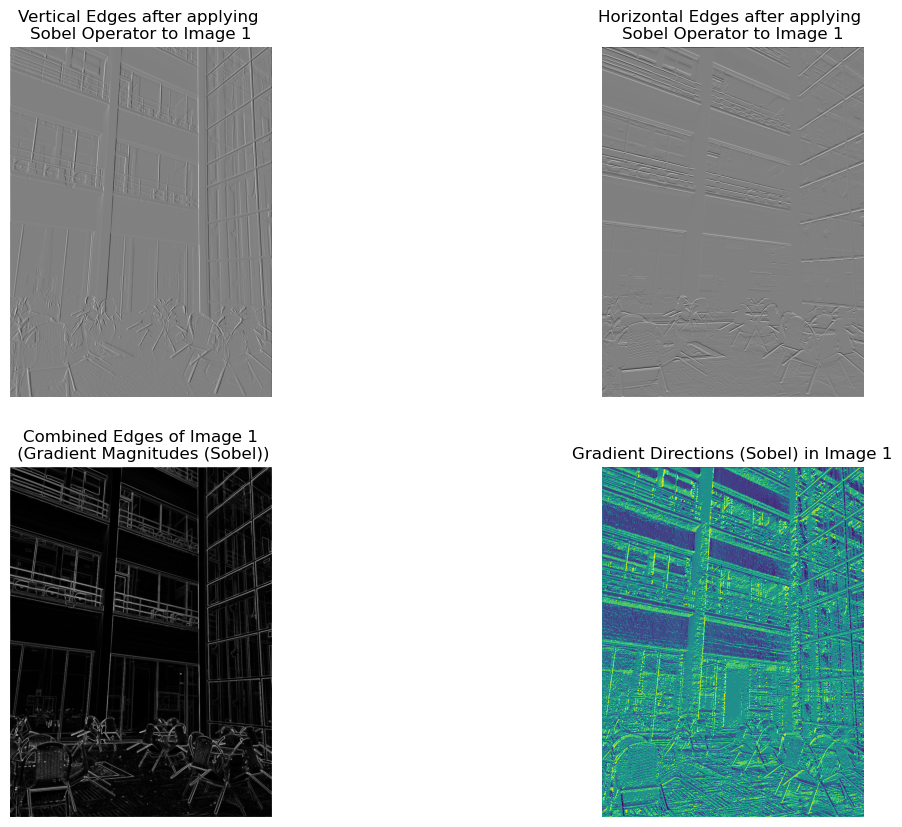

In [132]:
plot_results1(sobel_x1, sobel_y1, sobel_magnitudes1, sobel_directions1, (14, 10), 'Sobel', '1', save)

### Canny Edge Detector

**Step 1**: Apply Gaussian Blur to the image to reduce noise.

In [92]:
def gaussian_blur(sigma, k=2):
    """
    Generates a Gaussian Blur Filter with shape (2k + 1, 2k + 1), with
    the specified standard deviation.
    Args:
        sigma: The standard deviation of the Gaussian Blur
        k: The parameter that determines the shape of the filter (2 by default)
    Returns:
        G: The resulting Gaussian Blur Filter 
    """
    x, y = np.mgrid[-k: k + 1, -k: k + 1]
    G = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) / 2 * np.pi * sigma ** 2
    return G

Plot a Gaussian Blur Filter of shape 11x11 and sigma 1 for illustration purposes

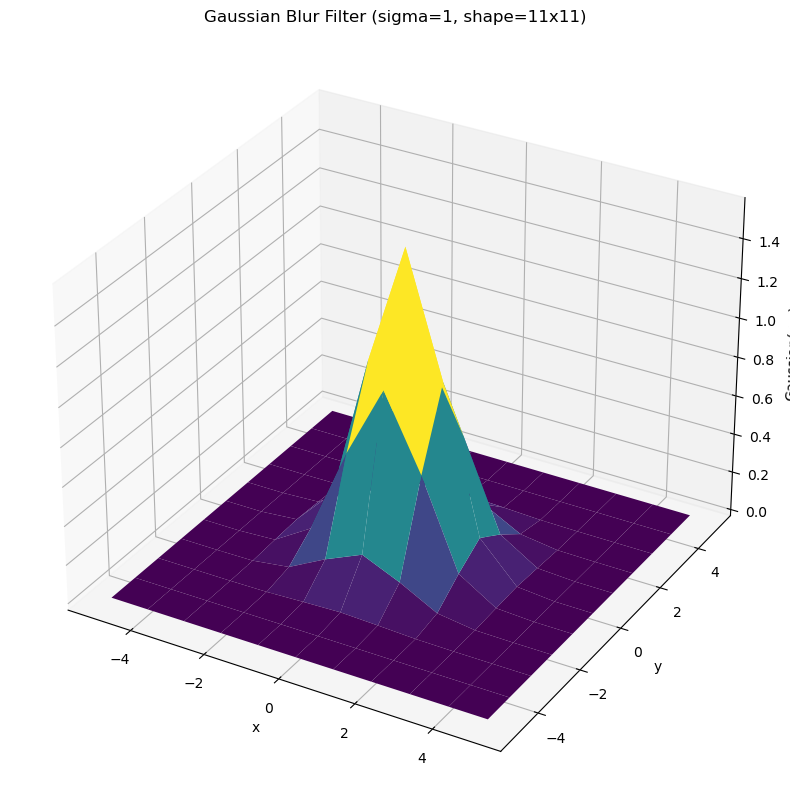

In [93]:
from mpl_toolkits import mplot3d # for 3D plotting

k_plt = 5
fig_3D = plt.figure(figsize=(15, 10))
ax_3D = plt.axes(projection='3d')
x_plt, y_plt = np.mgrid[-k_plt: k_plt + 1, -k_plt: k_plt + 1]
ax_3D.plot_surface(x_plt, y_plt, gaussian_blur(sigma=1, k=k_plt), rstride=1, cstride=1, 
                   cmap='viridis', edgecolor='none')
ax_3D.set_xlabel('x')
ax_3D.set_ylabel('y')
ax_3D.set_zlabel('Gaussian(x,y)')
plt.title('Gaussian Blur Filter (sigma=1, shape=11x11)')
#plt.savefig('gaussian_blur_3d.png')
plt.show()

**Step 2**: Gradient Calculation, use the **sobel** function implemented above for computing the graident magnitudes and directions. 

**Step 3**: Implement the Non-Maximum Suppression algorithm to thin out the detected edges.

In [94]:
def non_max_suppression(gradient_magnitudes, gradient_directions):
    """
    Implements the Non-Maximum Suppression algorithm to thin out the
    edges described as gradient magnitudes.
    Args:
        gradient_magnitudes: Edge intensities
        gradient_directions: Edge directions (angles in Radians)
    output:
        result: The processed edge intensities 
    """
   
       #INSER YOUR CODE HERE
    output = gradient_magnitudes
    for i in range(1, len(gradient_magnitudes)-2): #note: these loops completely ignore the border pixels. unsure what consequences will be brought
        for j in range(1, len(gradient_magnitudes[0])-2):
            
            if(gradient_directions[i][j] < 0):
                gradient_directions[i][j] += 2*math.pi
            
            if( #0 sector
                (gradient_directions[i][j] <= 2*math.pi and gradient_directions[i][j] > (15*math.pi)/8) or #0 slice below 0 degrees
                (gradient_directions[i][j] <= math.pi/8 and gradient_directions[i][j] >= 0) or #0 slice above zero degrees
                (gradient_directions[i][j] <= (9*math.pi)/8 and gradient_directions[i][j] > (7*math.pi)/8) #0 slice at 180 degrees
            ):
                mag_left = gradient_magnitudes[i-1][j]
                mag_right = gradient_magnitudes[i+1][j]
                if(gradient_magnitudes[i][j] < mag_left or gradient_magnitudes[i][j] < mag_right):
                    output[i][j] = 0; #suppresses pixels that have a lower magnituted than its neighbors
            elif( #1 sector
                (gradient_directions[i][j] <= (3*math.pi)/8 and gradient_directions[i][j] > math.pi/8) or #1 slice above 0 degrees
                (gradient_directions[i][j] <= (11*math.pi)/8 and gradient_directions[i][j] > (9*math.pi)/8) #1 slice below zero degrees
            ):
                mag_bottomleft = gradient_magnitudes[i-1][j+1]
                mag_topright = gradient_magnitudes[i+1][j-1]
                if(gradient_magnitudes[i][j] < mag_bottomleft or gradient_magnitudes[i][j] < mag_topright):
                    output[i][j] = 0; #suppresses pixels that have a lower magnituted than its neighbors
            elif( #2 sector
                (gradient_directions[i][j] <= (5*math.pi)/8 and gradient_directions[i][j] > (3*math.pi)/8) or #2 slice above 0 degrees
                (gradient_directions[i][j] <= (13*math.pi)/8 and gradient_directions[i][j] > (11*math.pi)/8) #2 slice below zero degrees
            ):
                mag_top = gradient_magnitudes[i][j-1]
                mag_bottom = gradient_magnitudes[i][j+1]
                if(gradient_magnitudes[i][j] < mag_top or gradient_magnitudes[i][j] < mag_bottom):
                    output[i][j] = 0; #suppresses pixels that have a lower magnituted than its neighbors
            elif( #3 sector
                (gradient_directions[i][j] <= (7*math.pi)/8 and gradient_directions[i][j] > (3*math.pi)/8) or #3 slice above 0 degrees
                (gradient_directions[i][j] <= (15*math.pi)/8 and gradient_directions[i][j] > (13*math.pi)/8) #3 slice below zero degrees
            ):
                mag_topleft = gradient_magnitudes[i-1][j-1]
                mag_bottomright = gradient_magnitudes[i+1][j+1]
                if(gradient_magnitudes[i][j] < mag_topleft or gradient_magnitudes[i][j] < mag_bottomright):
                    output[i][j] = 0; #suppresses pixels that have a lower magnituted than its neighbors
            else:
                print("something went wrong with the gradient direction processing")
                print("gradient direction: ")
                print(gradient_directions[i][j])
                return
    
    
    
    return output

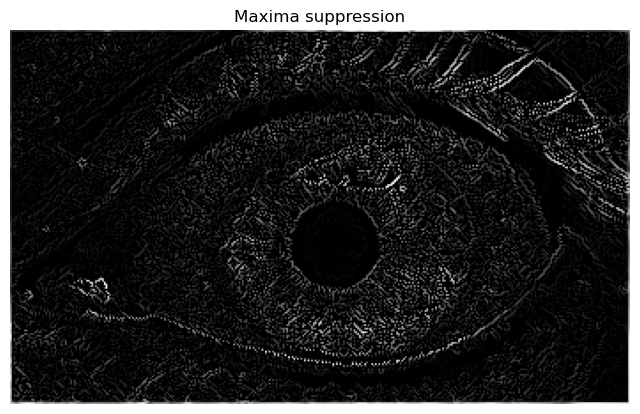

In [95]:
_, _, gradient_magnitudes, gradient_directions = sobel(img1)
nms_img = non_max_suppression(gradient_magnitudes, gradient_directions)

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Maxima suppression')
plt.imshow(nms_img, cmap='gray')
if save:
    plt.savefig('Maxima Suppression1.png')
plt.show()

**Step 4**: Implement the Double Thresholding algorithm to categorize pixels.

In [96]:
def double_threshold(img, ratio_low, ratio_high):
    """
    Categorizes the image pixels as strong, weak or non-edge
    using double thresholding, returns the thresholded image.
    Args:
        img: The input image
        ratio_low: The low threshold ratio 
        ratio_high: The high threshold ratio 
    Returns:
        thresholded_img: The thresholded output. Each pixel would take the value of 0, strong or weak intensities as set below. 
        weak: The intensity level of weak pixels
        strong: The intensity level of strong pixels
    """
    high = ratio_high * np.max(img)
    low = ratio_low * np.max(img)
    weak = 25
    strong = 255
    #print(np.max(img))
    
    #INSER YOUR CODE HERE
    thresholded_img = img
    for i in range(1, len(img)-2): #note: these loops completely ignore the border pixels. unsure what consequences will be brought
        #print("\n")
        for j in range(1, len(img[0])-2):
            #print()
            #print(img[i][j])
            if(img[i][j]>high):
                thresholded_img[i][j] = strong
            elif(img[i][j]<low):
                thresholded_img[i][j] = 0
            else:
                thresholded_img[i][j] = weak

    return thresholded_img, weak, strong

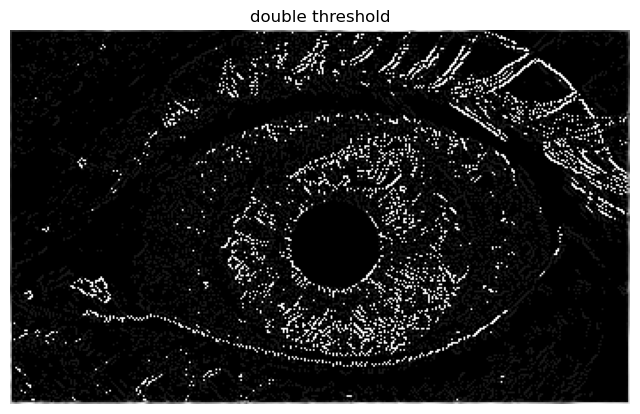

In [97]:
_, _, gradient_magnitudes, gradient_directions = sobel(img1)
nms_img = non_max_suppression(gradient_magnitudes, gradient_directions)
thresholded_img, weak, strong = double_threshold(nms_img, 0.1, 0.3)

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('double threshold')
plt.imshow(thresholded_img, cmap='gray')
if save:
    plt.savefig('Double Threshold1.png')
plt.show()

**Step 5**: Implement Hysteresis to combine the Strong and Weak pixels and produces the final result. 

In [98]:
def hysteresis(img, weak, strong):
    """
    Args:
        img: The input image
        weak: The weak intensity level
        strong: The strong intensity level
    Returns:
        output: The processed output image
    """
    #INSER YOUR CODE HERE
    output = img
    for i in range(1, len(img)-2): #note: these loops completely ignore the border pixels. unsure what consequences will be brought
        for j in range(1, len(img[0])-2):
            #define the neighbors to use in if statements
            topleft = img[i-1][j-1]
            top = img[i][j-1]
            topright = img[i+1][j-1]
            left = img[i-1][j]
            right = img[i+1][j]
            bottomleft = img[i-1][j+1]
            bottom = img[i][j+1]
            bottomright = img[i+1][j+1]
            
            if(img[i][j]==weak):
                if(
                    topleft==strong or top==strong or topright==strong or left==strong or 
                    right==strong or bottomleft==strong or bottom==strong or bottomright==strong
                ):
                    output[i][j]=strong
                else:
                    output[i][j]=0
    return output

Combine the five steps in a single algorithm:

In [99]:
def canny_edge_detector(img, sigma, ratio_low, ratio_high, k=2):
    """
    Applys Canny Edge Detection algorithm to a given image.
    Args:
        img: The input image
        sigma: The standard deviation of the 5x5 Gaussian Filter
           
        ratio_low: The low threshold ratio used in the Double Thresholding step
            
        ratio_high: The high threshold ratio used in the Double Thresholding step
            
        k: Parameter to adjust the shape of the (2k + 1, 2k + 1) gaussian blur 
    """
    G = gaussian_blur(sigma, k)
    blurred_img = cross_correlate2D(img, G)
    _, _, gradient_magnitudes, gradient_directions = sobel(blurred_img)
    nms_img = non_max_suppression(gradient_magnitudes, gradient_directions)
    thresholded_img, weak, strong = double_threshold(nms_img, ratio_low, ratio_high)
    output = hysteresis(thresholded_img, weak, strong)
    return output

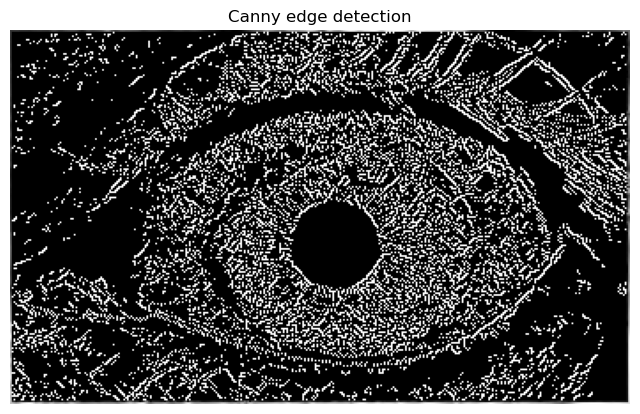

In [119]:
#G = gaussian_blur(0.5, 2)
#blurred_img = cross_correlate2D(img1, G)
import cv2
img1 = cv2.imread('edge3.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,0.5,0.1,0.1), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()

In [ ]:
'''
Add your results and answers to the questions 5.2.1, 5.2.2 and 5.2.3 here
Q5.2.1:
Image 1:
Low sigma value is better, because the majority of the edges in the image are in the thin leaves tightly packed
next to each other. By increasing the value of sigma, the input image becomes blurrier. With image1, this can cause
the individual leaf fronds to blur together, making it so they aren’t picked up by the edge detection. The image
also has some very light edges such as those on the horizon, clouds, and mountains in the background. In order to have
those picked up by the edge detector, keeping the ratio_high lower will make sure they’re present
Best parameters for edge1.png:
Sigma: 0.5, ratio_low: 0.05, ratio_high: 0.1
'''
img1 = cv2.imread('edge1.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,0.5,0.05,0.1), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()
'''
Image 2:
An average sigma is best as having one too high will cause the chairs to become too blurred to be seen and having
one too low will make them a mess of edges. Keeping the ratio_high low to ensure the chairs are picked up and the
ratio_low high to keep the chairs looking clean.
Best parameters:
Sigma: 1, ratio_low: 0.1, ratio_high: 0.12
'''
img1 = cv2.imread('edge2.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,1,0.1,0.12), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()
'''
Image 3:
The image has a lot of edges present in the iris that can cause the outcome image to look messy if they’re picked up. 
By increasing the sigma value and blurring the image more, they can be smoothed out to reduce the noise. 
Having a higher ratio_low will also help to reduce the noise and make the stronger edges stand out. 
Ratio_high is also kept low as the edges overall are not very strong
Best parameters:
Sigma: 2, ratio_low: 0.1, ratio_high: 0.15 
'''
img1 = cv2.imread('edge3.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,2,0.1,0.15), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()
'''
Q5.2.2
Image 1:
Sigma: 2, ratio_low: 0.05, ratio_high: 0.1
'''
img1 = cv2.imread('edge1.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,2,0.05,0.1), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()
'''
Sigma: 2, ratio_low: 0.01, ratio_high: 0.1
'''
img1 = cv2.imread('edge1.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,2,0.01,0.1), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()
"""Sigma: 0.5, ratio_low: 1, ratio_high: 1"""
img1 = cv2.imread('edge1.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,0.5,1,1), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()
"""Sigma: 0.5, ratio_low: 0.1, ratio_high: 0.1"""
img1 = cv2.imread('edge1.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,0.5,0.1,0.1), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()

'''
Image 2:
Sigma: 2, ratio_low: 0.05, ratio_high: 0.1
'''
img1 = cv2.imread('edge2.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,2,0.05,0.1), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()
'''
Sigma: 2, ratio_low: 0.01, ratio_high: 0.1
'''
img1 = cv2.imread('edge2.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,2,0.01,0.1), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()
"""Sigma: 0.5, ratio_low: 1, ratio_high: 1"""
img1 = cv2.imread('edge2.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,0.5,1,1), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()
"""Sigma: 0.5, ratio_low: 0.1, ratio_high: 0.1"""
img1 = cv2.imread('edge2.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,0.5,0.1,0.1), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()

'''
Image 3:
Sigma: 2, ratio_low: 0.05, ratio_high: 0.1
'''
img1 = cv2.imread('edge3.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,2,0.05,0.1), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()
'''
Sigma: 2, ratio_low: 0.01, ratio_high: 0.1
'''
img1 = cv2.imread('edge3.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,2,0.01,0.1), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()
"""Sigma: 0.5, ratio_low: 1, ratio_high: 1"""
img1 = cv2.imread('edge3.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,0.5,1,1), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()
"""Sigma: 0.5, ratio_low: 0.1, ratio_high: 0.1"""
img1 = cv2.imread('edge3.png', 0)
#img1 = rgb2gray(mpimg.imread('edge2.png'))

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Canny edge detection')
plt.imshow(canny_edge_detector(img1,0.5,0.1,0.1), cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()




"""5.2.3
I believe my results have improved upon the results from sobel. While the sobel filter is very good at acquiring all
the edges in a given image, this is not always wanted. If you are looking to detect only the stronger edges in an image,
that would be difficult using sobel, but canny would let you adjust the parameters until you get the image you are
looking for."""


In [156]:
def kernelsBuilder(): #creates arrays to use for the kernals in the sticks filter
    k = np.empty([8], np.ndarray )
    k[0] = np.array([[ 0   ,  0   ,  0   ,  0   ,  0   ], 
                   [ 0   ,  0   ,  0   ,  0   ,  0   ],
                   [(1/5), (1/5), (1/5), (1/5), (1/5)],
                   [ 0   ,  0   ,  0   ,  0   ,  0   ],
                   [ 0   ,  0   ,  0   ,  0   ,  0   ]])
    k[1] = np.array([[ 0   ,  0   ,  0   ,  0   ,  0   ], 
                   [ 0   ,  0   ,  0   , (1/5), (1/5)],
                   [ 0   ,  0   , (1/5),  0   ,  0   ],
                   [(1/5), (1/5),  0   ,  0   ,  0   ],
                   [ 0   ,  0   ,  0   ,  0   ,  0   ]])
    k[2] = np.array([[ 0   ,  0   ,  0   ,  0   , (1/5)], 
                   [ 0   ,  0   ,  0   , (1/5),  0   ],
                   [ 0   ,  0   , (1/5),  0   ,  0   ],
                   [ 0   , (1/5),  0   ,  0   ,  0   ],
                   [(1/5),  0   ,  0   ,  0   ,  0   ]])
    k[3] = np.array([[ 0   ,  0   ,  0   , (1/5),  0   ], 
                   [ 0   ,  0   ,  0   , (1/5),  0   ],
                   [ 0   ,  0   , (1/5),  0   ,  0   ],
                   [ 0   , (1/5),  0   ,  0   ,  0   ],
                   [ 0   , (1/5),  0   ,  0   ,  0   ]])
    k[4] = np.array([[ 0   ,  0   , (1/5),  0   ,  0   ], 
                   [ 0   ,  0   , (1/5),  0   ,  0   ],
                   [ 0   ,  0   , (1/5),  0   ,  0   ],
                   [ 0   ,  0   , (1/5),  0   ,  0   ],
                   [ 0   ,  0   , (1/5),  0   ,  0   ]])    
    k[5] = np.array([[ 0   , (1/5),  0   ,  0   ,  0   ], 
                   [ 0   , (1/5),  0   ,  0   ,  0   ],
                   [ 0   ,  0   , (1/5),  0   ,  0   ],
                   [ 0   ,  0   ,  0   , (1/5),  0   ],
                   [ 0   ,  0   ,  0   , (1/5),  0   ]])
    k[6] = np.array([[(1/5),  0   ,  0   ,  0   ,  0   ], 
                   [ 0   , (1/5),  0   ,  0   ,  0   ],
                   [ 0   ,  0   , (1/5),  0   ,  0   ],
                   [ 0   ,  0   ,  0   , (1/5),  0   ],
                   [ 0   ,  0   ,  0   ,  0   , (1/5)]])
    k[7] = np.array([[ 0   ,  0   ,  0   ,  0   ,  0   ], 
                   [(1/5), (1/5),  0   ,  0   ,  0   ],
                   [ 0   ,  0   , (1/5),  0   ,  0   ],
                   [ 0   ,  0   ,  0   , (1/5), (1/5)],
                   [ 0   ,  0   ,  0   ,  0   ,  0   ]])
    
    return k

In [159]:
def sticks_filter(gradient_magnitudes):
    kernels = kernelsBuilder()
    filters = np.empty([8], dtype= np.ndarray)
    
    output = gradient_magnitudes
    for i in range(8):
        filters[i] = cv.filter2D(gradient_magnitudes, -1, kernels[i])        
    for i in range (2, len(gradient_magnitudes)-2): #loops through the gradiant magnitude. saves the results of the kernal with the greatest effect
        for j in range(2, len(gradient_magnitudes[0])-2):
            neighbors = np.empty([5,5])
            x = 0
            y = 0
            for r in range(i-2, i+3):
                neighbors[x] = np.empty(5)
                for s in range(j-2, j+3):
                    neighbors[x][y] = gradient_magnitudes[r][s]
                    y += 1
                y = 0
                x += 1
            avgMag = average(neighbors)
            avgStickMag = np.empty(8)
            for m in range(8):
                avgStickMag[m] = averageMag(neighbors, kernels[m]) - avgMag
            output[i][j] = avgStickMag.max()
    return output

In [150]:
def average(m):
    sum = 0
    for i in range(len(m)):
        for j in range(len(m[0])):
            sum += m[i][j]
    return sum / (len(m)*(len(m[0])))
def averageMag(n, k):
    stick = n
    for i in range(5):
        for j in range(5):
            stick[i][j] = n[i][j]  * k[i][j] 
    avg = 0
    for i in range(5):
        for j in range(5):
            avg += stick[i][j] 
    return avg

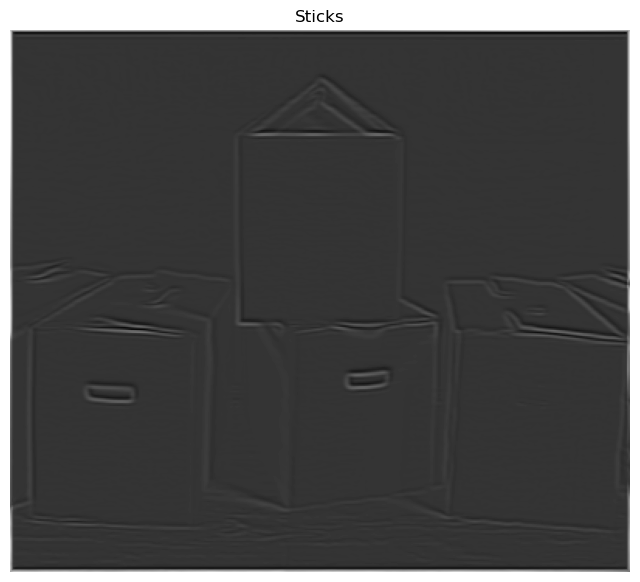

In [160]:
img1 = rgb2gray(mpimg.imread('edge4.jpg'))
'''
G = gaussian_blur(sigma, k)
blurred_img = cross_correlate2D(img, G)
_, _, gradient_magnitudes, gradient_directions = sobel(blurred_img)
nms_img = non_max_suppression(gradient_magnitudes, gradient_directions)
thresholded_img, weak, strong = double_threshold(nms_img, ratio_low, ratio_high)
output = hysteresis(thresholded_img, weak, strong)
'''
G = gaussian_blur(1, 2)
blurred_img = cross_correlate2D(img1, G)
_, _, gradient_magnitudes, gradient_directions = sobel(blurred_img)
sticks = sticks_filter(gradient_magnitudes)


plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Sticks')
plt.imshow(sticks, cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()

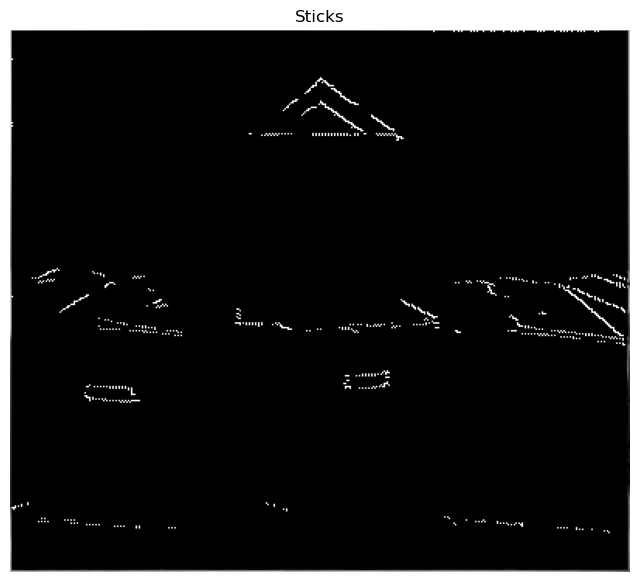

In [163]:
img1 = rgb2gray(mpimg.imread('edge4.jpg'))
'''
G = gaussian_blur(sigma, k)
blurred_img = cross_correlate2D(img, G)
_, _, gradient_magnitudes, gradient_directions = sobel(blurred_img)
nms_img = non_max_suppression(gradient_magnitudes, gradient_directions)
thresholded_img, weak, strong = double_threshold(nms_img, ratio_low, ratio_high)
output = hysteresis(thresholded_img, weak, strong)
'''
G = gaussian_blur(0.5, 2)
blurred_img = cross_correlate2D(img1, G)
_, _, gradient_magnitudes, gradient_directions = sobel(blurred_img)
sticks = sticks_filter(gradient_magnitudes)
nms_img = non_max_suppression(sticks, gradient_directions)
thresholded_img, weak, strong = double_threshold(nms_img, 0.01, 0.1)
output = hysteresis(thresholded_img, weak, strong)

plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Sticks')
plt.imshow(output, cmap='gray')#sigma: 1, ratio low: 0.09, ratio high: 0.25 canny_edge_detector(img1,2,0.1,0.15)
if save:
    plt.savefig('hysteresis1.png')
plt.show()